In [2]:
import os, random, numpy as np, cv2
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard import SummaryWriter
import segmentation_models_pytorch as smp
import skimage.filters as skf

# --------- Settings ---------
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_DIR = "/Users/imamahasan/MyData/Code/Retinal_Vessel_S/training/images"
MASK_DIR  = "/Users/imamahasan/MyData/Code/Retinal_Vessel_S/training/1st_manual"
BATCH_SIZE  = 4
INPUT_SIZE  = 512
EPOCHS      = 5
PATIENCE    = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY  = 1e-5

# --- Data Discovery ---
image_ext = ['tif', 'tiff']
mask_ext  = ['gif']

def find_files(folder, exts):
    files = []
    for ext in exts:
        files += glob(os.path.join(folder, f"*.{ext}"))
    return sorted(files)

imgs = find_files(IMAGE_DIR, image_ext)
msks = find_files(MASK_DIR, mask_ext)

print(f"Found {len(imgs)} images and {len(msks)} masks.")
if len(imgs) == 0 or len(msks) == 0:
    raise ValueError(f"No images or masks found. Check folders:\nImages: {IMAGE_DIR}\nMasks: {MASK_DIR}")

# Optional: Sort and match by name if needed
img_dict = {os.path.splitext(os.path.basename(f))[0].split('_')[0]: f for f in imgs}
msk_dict = {os.path.splitext(os.path.basename(f))[0].split('_')[0]: f for f in msks}
common_keys = sorted(set(img_dict) & set(msk_dict))
imgs = [img_dict[k] for k in common_keys]
msks = [msk_dict[k] for k in common_keys]
print(f"Matched {len(imgs)} image-mask pairs.")

if len(imgs) != len(msks):
    raise ValueError("Image/Mask count mismatch after pairing. Check file naming!")

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
def vesselness_prior(img_np):
    green = img_np[..., 1]
    cl = clahe.apply(green)
    fr = skf.frangi(cl / 255.0)
    frn = ((fr - fr.min()) / (np.ptp(fr) + 1e-6) * 255).astype(np.uint8)
    return np.stack([frn]*3, axis=-1)

class VesselDataset(Dataset):
    def __init__(self, images, masks, augment=False):
        self.imgs = images
        self.msks = masks
        self.transform = A.Compose([
            A.Resize(INPUT_SIZE, INPUT_SIZE),
            A.HorizontalFlip(p=0.5) if augment else A.NoOp(),
            A.RandomBrightnessContrast(p=0.2) if augment else A.NoOp(),
            A.Normalize(mean=(0.5,)*3, std=(0.5,)*3),
            ToTensorV2()
        ])
    def __len__(self): return len(self.imgs)
    def __getitem__(self, idx):
        img = np.array(Image.open(self.imgs[idx]).convert("RGB"))
        msk = (np.array(Image.open(self.msks[idx]).convert("L")) > 0).astype(np.uint8)
        img = self.transform(image=img)["image"]
        msk = torch.tensor(msk).unsqueeze(0).float()
        return img, msk

# ------- Model Components --------
class SEBlock(nn.Module):
    def __init__(self, ch, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(ch, ch // reduction)
        self.fc2 = nn.Linear(ch // reduction, ch)
    def forward(self, x):
        b,c,h,w = x.size()
        y = x.reshape(b, c, -1).mean(-1)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).reshape(b, c, 1, 1)
        return x * y

class ResidualSEBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.se = SEBlock(out_ch)
        self.res = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.dropblock = nn.Dropout2d(0.15)
    def forward(self, x):
        res = self.res(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = self.se(x)
        x = self.dropblock(x)
        return F.relu(x + res)

class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 1)
        self.conv6 = nn.Conv2d(in_ch, out_ch, 3, padding=6, dilation=6)
        self.conv12 = nn.Conv2d(in_ch, out_ch, 3, padding=12, dilation=12)
        self.conv18 = nn.Conv2d(in_ch, out_ch, 3, padding=18, dilation=18)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.proj = nn.Conv2d(out_ch*5, out_ch, 1)
    def forward(self, x):
        p = F.interpolate(self.pool(x), size=x.shape[-2:], mode='bilinear', align_corners=False)
        out = torch.cat([self.conv1(x), self.conv6(x), self.conv12(x), self.conv18(x), p], dim=1)
        return self.proj(out)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1, bias=True), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1, bias=True), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1, bias=True), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        # Match spatial dims
        if g1.shape[2:] != x1.shape[2:]:
            x1 = F.interpolate(x1, size=g1.shape[2:], mode='bilinear', align_corners=False)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class CBAM(nn.Module):
    def __init__(self, ch, reduction=16, kernel_size=7):
        super().__init__()
        self.channel = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ch, ch // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(ch // reduction, ch, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        # Channel
        avg = self.channel(x)
        x = x * avg
        # Spatial
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spat = self.spatial(torch.cat([avg_out, max_out], dim=1))
        return x * spat

class UpBlock(nn.Module):
    def __init__(self, up_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(up_ch, out_ch, 1)
        )
        self.cbam = CBAM(skip_ch)
        self.block = nn.Sequential(
            ResidualSEBlock(out_ch+skip_ch, out_ch),
            nn.Dropout2d(0.15)
        )
        self.att_gate = AttentionGate(out_ch, skip_ch, out_ch // 2)
    def forward(self, x, skip):
        x = self.up(x)
        if skip.shape[2:] != x.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
        skip = self.cbam(skip)
        skip = self.att_gate(x, skip)
        x = torch.cat([x, skip], dim=1)
        return self.block(x)

# -------- Main Model ---------
class TransVesselPINet(nn.Module):
    def __init__(self, encoder_name='resnet34', deep_supervision=True, uncertainty=True):
        super().__init__()
        self.encoder = smp.encoders.get_encoder(
            encoder_name, in_channels=3, depth=5, weights='imagenet'
        )
        chs = self.encoder.out_channels  # e.g., [3, 64, 64, 128, 256, 512]
        print("Encoder channels:", chs)
        self.bridge = ResidualSEBlock(chs[-1], chs[-1])
        self.aspp = ASPP(chs[-1], chs[-1])
        self.up4 = UpBlock(chs[-1], chs[-2], chs[-2])
        self.up3 = UpBlock(chs[-2], chs[-3], chs[-3])
        self.up2 = UpBlock(chs[-3], chs[-4], chs[-4])
        self.up1 = UpBlock(chs[-4], chs[-5], chs[-5])
        self.out_seg = nn.Conv2d(chs[-5], 1, 1)
        self.deep_supervision = deep_supervision
        self.uncertainty = uncertainty
        if self.uncertainty:
            self.out_var = nn.Conv2d(chs[-5], 1, 1)
        if self.deep_supervision:
            self.ds4 = nn.Conv2d(chs[-2], 1, 1)
            self.ds3 = nn.Conv2d(chs[-3], 1, 1)
            self.ds2 = nn.Conv2d(chs[-4], 1, 1)

    def forward(self, x):
        feats = self.encoder(x)
        x = self.aspp(self.bridge(feats[-1]))
        u4 = self.up4(x, feats[-2])
        u3 = self.up3(u4, feats[-3])
        u2 = self.up2(u3, feats[-4])
        u1 = self.up1(u2, feats[-5])
        seg = torch.sigmoid(self.out_seg(u1))
        if self.uncertainty:
            var = F.softplus(self.out_var(u1))
        if self.deep_supervision:
            ds_outs = [
                torch.sigmoid(self.ds4(u4)),
                torch.sigmoid(self.ds3(u3)),
                torch.sigmoid(self.ds2(u2))
            ]
            if self.uncertainty:
                return (seg, ds_outs), var
            else:
                return (seg, ds_outs)
        else:
            if self.uncertainty:
                return seg, var
            else:
                return seg

# --------- Losses and Metrics ---------
def dice_loss(pred, targ, eps=1e-6):
    pred = pred.contiguous()
    targ = targ.contiguous()
    intersection = (pred * targ).sum()
    union = pred.sum() + targ.sum()
    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice

def focal_loss(pred, targ, alpha=0.8, gamma=2.):
    bce = F.binary_cross_entropy(pred, targ, reduction='none')
    pt = torch.exp(-bce)
    loss = alpha * (1-pt)**gamma * bce
    return loss.mean()

def multi_scale_loss(preds, targ, weights=[0.6,0.2,0.1,0.1]):
    main, ds = preds[0], preds[1]
    main = F.interpolate(main, size=targ.shape[-2:], mode='bilinear', align_corners=False)
    loss = weights[0]*dice_loss(main, targ)
    for w, p in zip(weights[1:], ds):
        p_up = F.interpolate(p, size=targ.shape[-2:], mode='bilinear', align_corners=False)
        loss += w * dice_loss(p_up, targ)
    loss += 0.3*focal_loss(main, targ)
    return loss

def uncertainty_loss(pred, targ, logvar):
    pred = F.interpolate(pred, size=targ.shape[-2:], mode='bilinear', align_corners=False)
    logvar = F.interpolate(logvar, size=targ.shape[-2:], mode='bilinear', align_corners=False)
    bce = F.binary_cross_entropy(pred, targ, reduction='none')
    return torch.mean(torch.exp(-logvar) * bce + logvar)

def dice_score_func(pred, targ, eps=1e-6):
    pred = F.interpolate(pred, size=targ.shape[-2:], mode='bilinear', align_corners=False)
    p = (pred>0.5).float(); t = targ
    tp = (p*t).sum(); fp=(p*(1-t)).sum(); fn=((1-p)*t).sum()
    return ((2*tp+eps)/(2*tp+fp+fn+eps)).item()

# -------- Data Loading ---------
tr_i,vl_i,tr_m,vl_m = train_test_split(imgs, msks, test_size=0.2, random_state=SEED)
train_loader = DataLoader(VesselDataset(tr_i, tr_m, augment=True), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(VesselDataset(vl_i, vl_m, augment=False), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# -------- Training Loop ---------
model = TransVesselPINet(deep_supervision=True, uncertainty=True).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
writer = SummaryWriter('runs/transvesselpi')
best_dice, no_imp, overlays = 0, 0, []

for epoch in range(1, EPOCHS+1):
    model.train(); t_loss, t_dice = 0, 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred_out = model(x)
        if isinstance(pred_out, tuple):
            (pred, ds_outs), var = pred_out
            loss_main = multi_scale_loss((pred, ds_outs), y)
            loss_unc = uncertainty_loss(pred, y, var)
            loss = loss_main + 0.2*loss_unc
            out_pred = pred
        else:
            pred, var = pred_out
            loss = dice_loss(pred, y) + 0.2*uncertainty_loss(pred, y, var)
            out_pred = pred
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        if out_pred.shape != y.shape:
            out_pred = F.interpolate(out_pred, size=y.shape[-2:], mode='bilinear', align_corners=False)
        t_loss += loss.item(); t_dice += dice_score_func(out_pred, y)
    t_loss /= len(train_loader); t_dice /= len(train_loader)
    model.eval(); v_loss, v_dice = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred_out = model(x)
            if isinstance(pred_out, tuple):
                (pred, ds_outs), var = pred_out
            else:
                pred, var = pred_out
            if pred.shape != y.shape:
                pred = F.interpolate(pred, size=y.shape[-2:], mode='bilinear', align_corners=False)
            v_loss += dice_loss(pred, y).item()
            v_dice += dice_score_func(pred, y)
            # Save overlays for only EPOCHS times
            if len(overlays) < EPOCHS:
                ov = (x[0].detach().cpu().permute(1,2,0).numpy() * 0.5 + 0.5) * 255
                mp = pred[0,0].detach().cpu().numpy()
                # Fix overlay size mismatch
                if mp.shape != ov.shape[:2]:
                    mp = cv2.resize(mp, (ov.shape[1], ov.shape[0]), interpolation=cv2.INTER_LINEAR)
                overlays.append(((ov*0.7 + mp[...,None]*255*0.3)).astype(np.uint8))
    v_loss /= len(val_loader); v_dice /= len(val_loader)
    writer.add_scalar('Loss/train', t_loss, epoch)
    writer.add_scalar('Dice/train', t_dice, epoch)
    writer.add_scalar('Loss/val', v_loss, epoch)
    writer.add_scalar('Dice/val', v_dice, epoch)
    print(f"Epoch {epoch:02d}: TL {t_loss:.3f}, TD {t_dice:.3f} | VL {v_loss:.3f}, VD {v_dice:.3f} (Best {best_dice:.3f})")
    if v_dice > best_dice:
        best_dice = v_dice; torch.save(model.state_dict(), 'best_transvesselpi.pth'); no_imp = 0
        print(f"New best model saved at epoch {epoch}")
    else:
        no_imp += 1
    scheduler.step()
    if no_imp >= PATIENCE:
        print("Early stopping!")
        break

writer.close()
print("Training complete. Best validation dice:", best_dice)


Found 20 images and 20 masks.
Matched 20 image-mask pairs.
Encoder channels: [3, 64, 64, 128, 256, 512]
Epoch 01: TL 1.092, TD 0.143 | VL 0.848, VD 0.000 (Best 0.000)
New best model saved at epoch 1
Epoch 02: TL 1.078, TD 0.177 | VL 0.848, VD 0.000 (Best 0.000)
Epoch 03: TL 1.073, TD 0.214 | VL 0.847, VD 0.000 (Best 0.000)
Epoch 04: TL 1.069, TD 0.224 | VL 0.847, VD 0.000 (Best 0.000)
New best model saved at epoch 4
Epoch 05: TL 1.062, TD 0.221 | VL 0.847, VD 0.176 (Best 0.000)
New best model saved at epoch 5
Training complete. Best validation dice: 0.1757974773645401


/var/folders/qk/szcdgwl97f98j7b69xpwh2200000gn/T/ipykernel_1465/1791353838.py:96: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.2, alpha=120, sigma=120*0.05, alpha_affine=120*0.03),


Visualizing sample images/masks from training set...


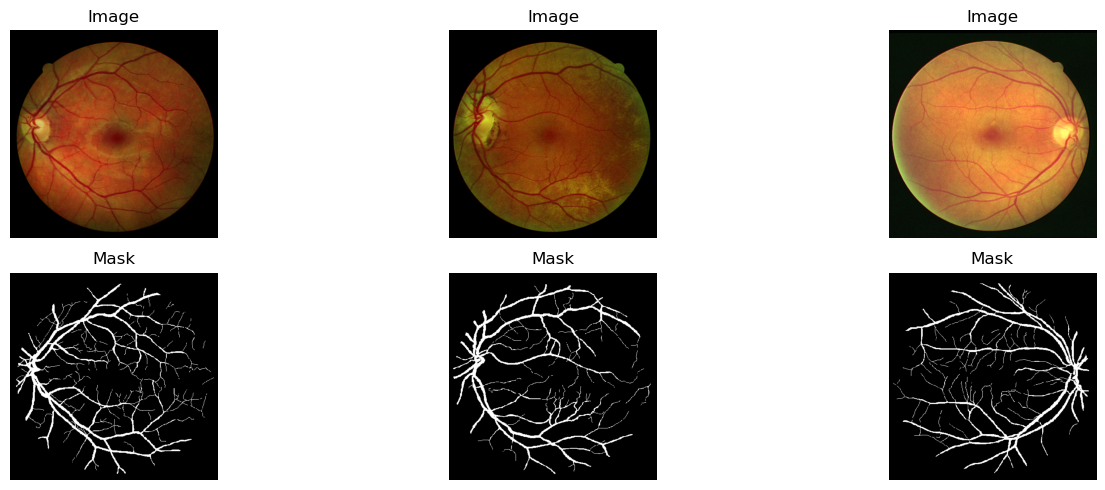


Starting training on mps ...

Epoch 01: TL 1.280, TD 0.148 | VL 0.848, VD 0.000 (Best 0.000)
New best model saved at epoch 1
Epoch 02: TL 1.261, TD 0.215 | VL 0.847, VD 0.000 (Best 0.000)
Epoch 03: TL 1.250, TD 0.261 | VL 0.848, VD 0.000 (Best 0.000)
Epoch 04: TL 1.235, TD 0.277 | VL 0.846, VD 0.004 (Best 0.000)
New best model saved at epoch 4
Epoch 05: TL 1.220, TD 0.291 | VL 0.846, VD 0.317 (Best 0.004)
New best model saved at epoch 5
Epoch 06: TL 1.204, TD 0.303 | VL 0.841, VD 0.320 (Best 0.317)
New best model saved at epoch 6
Epoch 07: TL 1.194, TD 0.309 | VL 0.836, VD 0.339 (Best 0.320)
New best model saved at epoch 7
Epoch 08: TL 1.184, TD 0.328 | VL 0.831, VD 0.382 (Best 0.339)
New best model saved at epoch 8
Epoch 09: TL 1.167, TD 0.363 | VL 0.825, VD 0.477 (Best 0.382)
New best model saved at epoch 9
Epoch 10: TL 1.157, TD 0.399 | VL 0.812, VD 0.505 (Best 0.477)
New best model saved at epoch 10
Epoch 11: TL 1.146, TD 0.425 | VL 0.791, VD 0.499 (Best 0.505)
Epoch 12: TL 1.129,

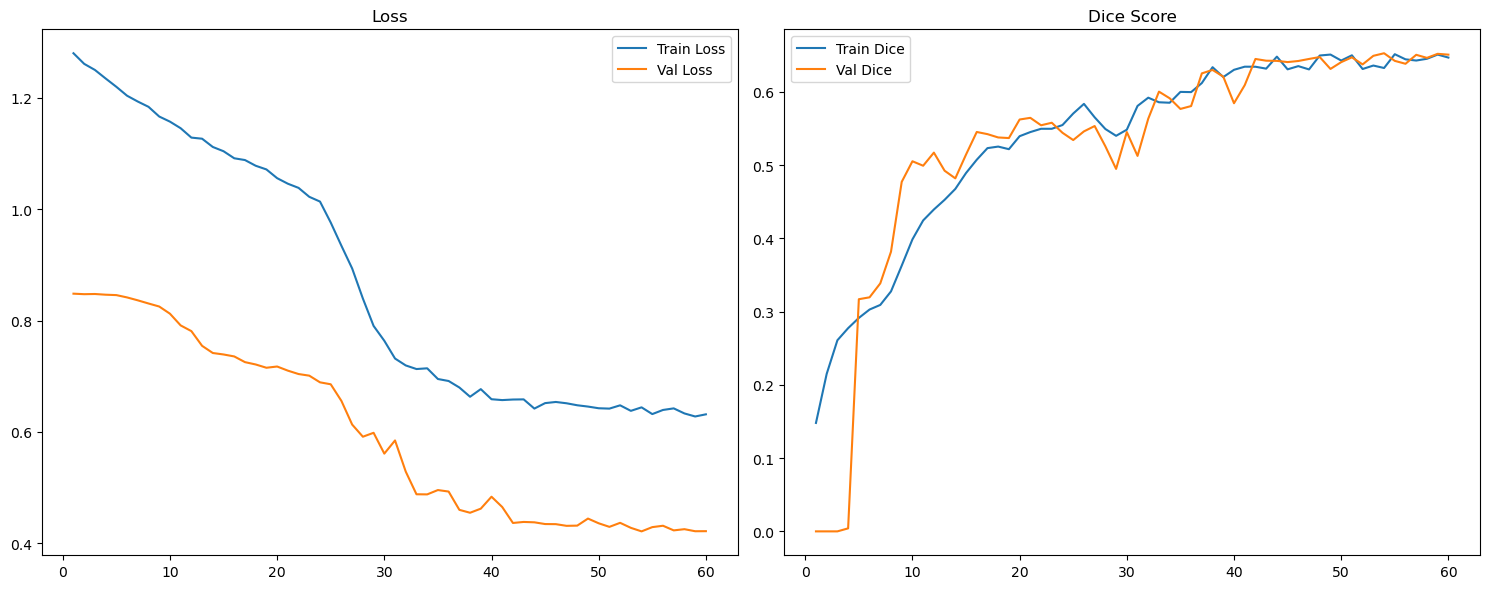

Showing overlays (input image + mask prediction):


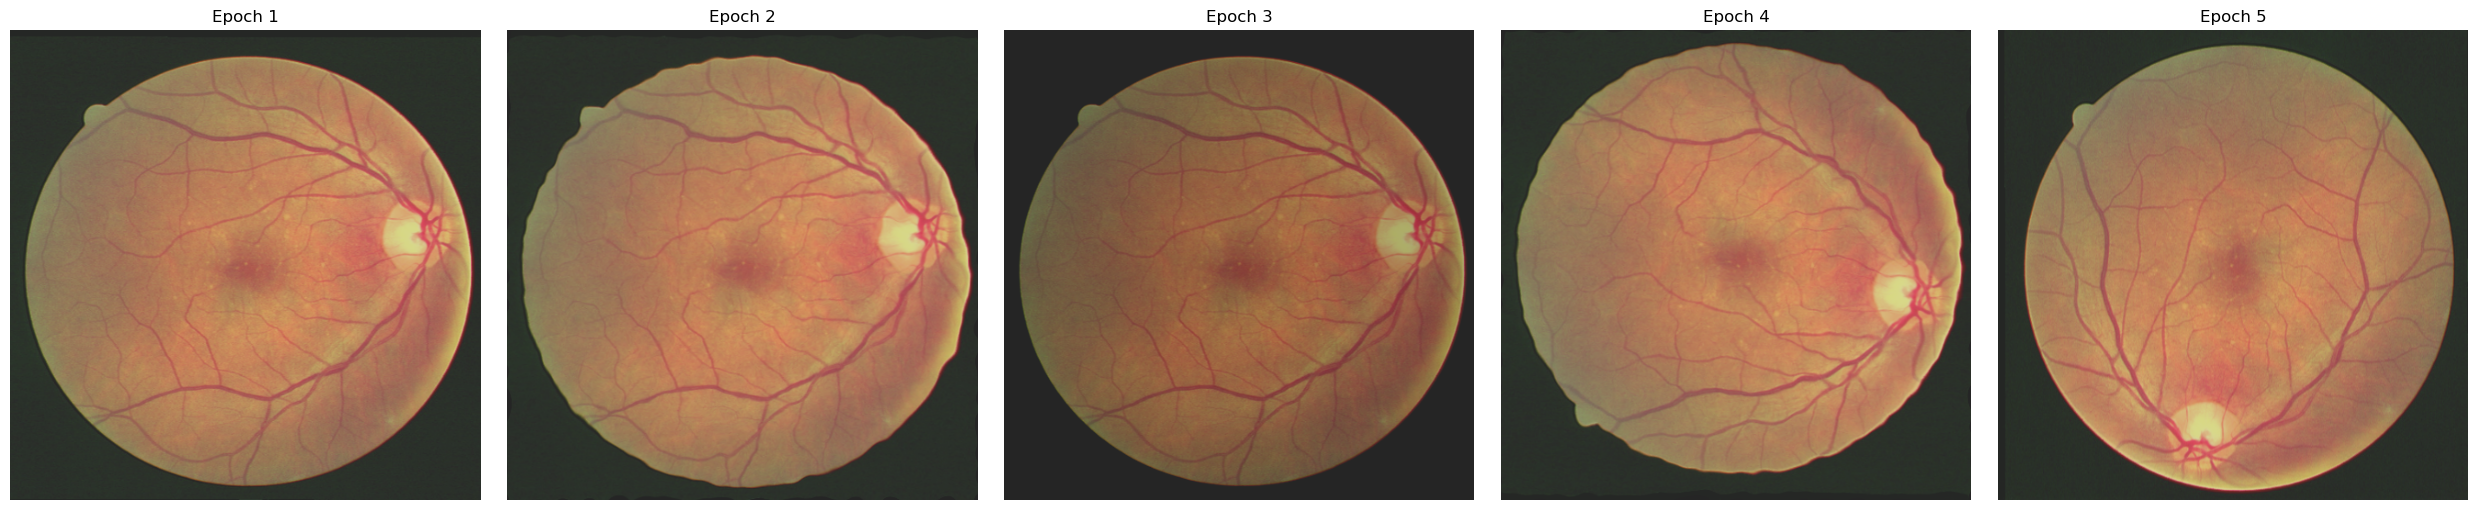

Framework complete! Best validation dice: 0.653


In [1]:
# main.py
import os, random, numpy as np, cv2
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard import SummaryWriter
import segmentation_models_pytorch as smp
import skimage.filters as skf
import matplotlib.pyplot as plt

# ============ CONFIG ==============
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_DIR = "/Users/imamahasan/MyData/Code/Retinal_Vessel_S/training/images"
MASK_DIR  = "/Users/imamahasan/MyData/Code/Retinal_Vessel_S/training/1st_manual"
BATCH_SIZE = 4
INPUT_SIZE = 512
EPOCHS = 60
PATIENCE = 12
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
RUN_NAME = 'UltimateVesselNet'

# ============ UTILITIES ===========
def find_files(folder, exts):
    files = []
    for ext in exts:
        files += glob(os.path.join(folder, f"*.{ext}"))
    return sorted(files)

def show_examples(dataset, num=3):
    plt.figure(figsize=(num*5, 5))
    for i in range(num):
        img, msk = dataset[i]
        plt.subplot(2, num, i+1)
        plt.imshow(img.permute(1,2,0).cpu().numpy()*0.5+0.5)
        plt.title("Image"); plt.axis('off')
        plt.subplot(2, num, i+1+num)
        plt.imshow(msk[0].cpu(), cmap='gray')
        plt.title("Mask"); plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_metrics(log, savepath=None):
    epochs = range(1, len(log['train_loss'])+1)
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.plot(epochs, log['train_loss'], label='Train Loss')
    plt.plot(epochs, log['val_loss'], label='Val Loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(epochs, log['train_dice'], label='Train Dice')
    plt.plot(epochs, log['val_dice'], label='Val Dice')
    plt.legend(); plt.title('Dice Score')
    plt.tight_layout()
    if savepath: plt.savefig(savepath)
    plt.show()

# ============ DATA HANDLING ============
image_ext = ['tif', 'tiff']
mask_ext = ['gif']

imgs = find_files(IMAGE_DIR, image_ext)
msks = find_files(MASK_DIR, mask_ext)
assert len(imgs) > 0 and len(msks) > 0, f"No images/masks found. Check paths: {IMAGE_DIR}, {MASK_DIR}"

# Auto-match by number (e.g. 21_training.tif with 21_manual1.gif)
img_dict = {os.path.splitext(os.path.basename(f))[0].split('_')[0]: f for f in imgs}
msk_dict = {os.path.splitext(os.path.basename(f))[0].split('_')[0]: f for f in msks}
common_keys = sorted(set(img_dict) & set(msk_dict))
imgs = [img_dict[k] for k in common_keys]
msks = [msk_dict[k] for k in common_keys]
assert len(imgs) == len(msks), "Images and masks count mismatch after matching!"

# ============ DATASET ==============
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
class VesselDataset(Dataset):
    def __init__(self, images, masks, augment=False):
        self.imgs = images
        self.msks = masks
        self.augment = augment
        self.transform = A.Compose([
            A.Resize(INPUT_SIZE, INPUT_SIZE),
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ElasticTransform(p=0.2, alpha=120, sigma=120*0.05, alpha_affine=120*0.03),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=(0.5,)*3, std=(0.5,)*3),
            ToTensorV2()
        ])
    def __len__(self): return len(self.imgs)
    def __getitem__(self, idx):
        img = np.array(Image.open(self.imgs[idx]).convert("RGB"))
        # Apply CLAHE to green channel
        img[...,1] = clahe.apply(img[...,1])
        msk = (np.array(Image.open(self.msks[idx]).convert("L")) > 0).astype(np.uint8)
        if self.augment:
            transformed = self.transform(image=img, mask=msk)
            img, msk = transformed['image'], transformed['mask']
        else:
            transformed = self.transform(image=img, mask=msk)
            img, msk = transformed['image'], transformed['mask']
        return img, msk.unsqueeze(0).float()

# ============ MODEL COMPONENTS =============
class SEBlock(nn.Module):
    def __init__(self, ch, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(ch, ch // reduction)
        self.fc2 = nn.Linear(ch // reduction, ch)
    def forward(self, x):
        b,c,h,w = x.size()
        y = x.reshape(b, c, -1).mean(-1)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).reshape(b, c, 1, 1)
        return x * y

class ResidualSEBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.se = SEBlock(out_ch)
        self.res = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.dropblock = nn.Dropout2d(0.15)
    def forward(self, x):
        res = self.res(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = self.se(x)
        x = self.dropblock(x)
        return F.relu(x + res)

class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 1)
        self.conv6 = nn.Conv2d(in_ch, out_ch, 3, padding=6, dilation=6)
        self.conv12 = nn.Conv2d(in_ch, out_ch, 3, padding=12, dilation=12)
        self.conv18 = nn.Conv2d(in_ch, out_ch, 3, padding=18, dilation=18)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.proj = nn.Conv2d(out_ch*5, out_ch, 1)
    def forward(self, x):
        p = F.interpolate(self.pool(x), size=x.shape[-2:], mode='bilinear', align_corners=False)
        out = torch.cat([self.conv1(x), self.conv6(x), self.conv12(x), self.conv18(x), p], dim=1)
        return self.proj(out)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1, bias=True), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1, bias=True), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1, bias=True), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        if g1.shape[2:] != x1.shape[2:]:
            x1 = F.interpolate(x1, size=g1.shape[2:], mode='bilinear', align_corners=False)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class CBAM(nn.Module):
    def __init__(self, ch, reduction=16, kernel_size=7):
        super().__init__()
        self.channel = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ch, ch // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(ch // reduction, ch, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        avg = self.channel(x)
        x = x * avg
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spat = self.spatial(torch.cat([avg_out, max_out], dim=1))
        return x * spat

class UpBlock(nn.Module):
    def __init__(self, up_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(up_ch, out_ch, 1)
        )
        self.cbam = CBAM(skip_ch)
        self.block = nn.Sequential(
            ResidualSEBlock(out_ch+skip_ch, out_ch),
            nn.Dropout2d(0.15)
        )
        self.att_gate = AttentionGate(out_ch, skip_ch, out_ch // 2)
    def forward(self, x, skip):
        x = self.up(x)
        if skip.shape[2:] != x.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
        skip = self.cbam(skip)
        skip = self.att_gate(x, skip)
        x = torch.cat([x, skip], dim=1)
        return self.block(x)

class TransVesselPINet(nn.Module):
    def __init__(self, encoder_name='resnet34', deep_supervision=True, uncertainty=True):
        super().__init__()
        self.encoder = smp.encoders.get_encoder(
            encoder_name, in_channels=3, depth=5, weights='imagenet'
        )
        chs = self.encoder.out_channels
        self.bridge = ResidualSEBlock(chs[-1], chs[-1])
        self.aspp = ASPP(chs[-1], chs[-1])
        self.up4 = UpBlock(chs[-1], chs[-2], chs[-2])
        self.up3 = UpBlock(chs[-2], chs[-3], chs[-3])
        self.up2 = UpBlock(chs[-3], chs[-4], chs[-4])
        self.up1 = UpBlock(chs[-4], chs[-5], chs[-5])
        self.out_seg = nn.Conv2d(chs[-5], 1, 1)
        self.deep_supervision = deep_supervision
        self.uncertainty = uncertainty
        if self.uncertainty:
            self.out_var = nn.Conv2d(chs[-5], 1, 1)
        if self.deep_supervision:
            self.ds4 = nn.Conv2d(chs[-2], 1, 1)
            self.ds3 = nn.Conv2d(chs[-3], 1, 1)
            self.ds2 = nn.Conv2d(chs[-4], 1, 1)
    def forward(self, x):
        feats = self.encoder(x)
        x = self.aspp(self.bridge(feats[-1]))
        u4 = self.up4(x, feats[-2])
        u3 = self.up3(u4, feats[-3])
        u2 = self.up2(u3, feats[-4])
        u1 = self.up1(u2, feats[-5])
        seg = torch.sigmoid(self.out_seg(u1))
        if self.uncertainty:
            var = F.softplus(self.out_var(u1))
        if self.deep_supervision:
            ds_outs = [
                torch.sigmoid(self.ds4(u4)),
                torch.sigmoid(self.ds3(u3)),
                torch.sigmoid(self.ds2(u2))
            ]
            if self.uncertainty:
                return (seg, ds_outs), var
            else:
                return (seg, ds_outs)
        else:
            if self.uncertainty:
                return seg, var
            else:
                return seg

# ============ LOSS & METRIC =============
def dice_loss(pred, targ, eps=1e-6):
    pred = pred.contiguous(); targ = targ.contiguous()
    intersection = (pred * targ).sum()
    union = pred.sum() + targ.sum()
    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice

def bce_dice_loss(pred, targ):
    bce = F.binary_cross_entropy(pred, targ)
    dice = dice_loss(pred, targ)
    return 0.5 * bce + 0.5 * dice

def multi_scale_loss(preds, targ, weights=[0.6,0.2,0.1,0.1]):
    main, ds = preds[0], preds[1]
    main = F.interpolate(main, size=targ.shape[-2:], mode='bilinear', align_corners=False)
    loss = weights[0]*dice_loss(main, targ)
    for w, p in zip(weights[1:], ds):
        p_up = F.interpolate(p, size=targ.shape[-2:], mode='bilinear', align_corners=False)
        loss += w * dice_loss(p_up, targ)
    loss += 0.3*bce_dice_loss(main, targ)
    return loss

def uncertainty_loss(pred, targ, logvar):
    pred = F.interpolate(pred, size=targ.shape[-2:], mode='bilinear', align_corners=False)
    logvar = F.interpolate(logvar, size=targ.shape[-2:], mode='bilinear', align_corners=False)
    bce = F.binary_cross_entropy(pred, targ, reduction='none')
    return torch.mean(torch.exp(-logvar) * bce + logvar)

def dice_score_func(pred, targ, eps=1e-6):
    pred = F.interpolate(pred, size=targ.shape[-2:], mode='bilinear', align_corners=False)
    p = (pred>0.5).float(); t = targ
    tp = (p*t).sum(); fp=(p*(1-t)).sum(); fn=((1-p)*t).sum()
    return ((2*tp+eps)/(2*tp+fp+fn+eps)).item()

# ============ TRAIN/VAL SPLIT =============
tr_i, vl_i, tr_m, vl_m = train_test_split(imgs, msks, test_size=0.2, random_state=SEED)
train_set = VesselDataset(tr_i, tr_m, augment=True)
val_set = VesselDataset(vl_i, vl_m, augment=False)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Visual check
print("Visualizing sample images/masks from training set...")
show_examples(train_set)

# ============ TRAINING =============
model = TransVesselPINet(deep_supervision=True, uncertainty=True).to(DEVICE)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
writer = SummaryWriter(f'runs/{RUN_NAME}')
best_dice, no_imp = 0, 0
log = {'train_loss':[], 'val_loss':[], 'train_dice':[], 'val_dice':[]}
overlays = []

print(f"\nStarting training on {DEVICE} ...\n")
for epoch in range(1, EPOCHS+1):
    model.train(); t_loss, t_dice = 0, 0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred_out = model(x)
        if isinstance(pred_out, tuple):
            (pred, ds_outs), var = pred_out
            loss_main = multi_scale_loss((pred, ds_outs), y)
            loss_unc = uncertainty_loss(pred, y, var)
            loss = loss_main + 0.2*loss_unc
            out_pred = pred
        else:
            pred, var = pred_out
            loss = bce_dice_loss(pred, y) + 0.2*uncertainty_loss(pred, y, var)
            out_pred = pred
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        if out_pred.shape != y.shape:
            out_pred = F.interpolate(out_pred, size=y.shape[-2:], mode='bilinear', align_corners=False)
        t_loss += loss.item(); t_dice += dice_score_func(out_pred, y)
    t_loss /= len(train_loader); t_dice /= len(train_loader)
    model.eval(); v_loss, v_dice = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred_out = model(x)
            if isinstance(pred_out, tuple):
                (pred, ds_outs), var = pred_out
            else:
                pred, var = pred_out
            if pred.shape != y.shape:
                pred = F.interpolate(pred, size=y.shape[-2:], mode='bilinear', align_corners=False)
            v_loss += dice_loss(pred, y).item()
            v_dice += dice_score_func(pred, y)
            if len(overlays) < EPOCHS:
                ov = (x[0].detach().cpu().permute(1,2,0).numpy() * 0.5 + 0.5) * 255
                mp = pred[0,0].detach().cpu().numpy()
                if mp.shape != ov.shape[:2]:
                    mp = cv2.resize(mp, (ov.shape[1], ov.shape[0]), interpolation=cv2.INTER_LINEAR)
                overlays.append(((ov*0.7 + mp[...,None]*255*0.3)).astype(np.uint8))
    v_loss /= len(val_loader); v_dice /= len(val_loader)
    writer.add_scalar('Loss/train', t_loss, epoch)
    writer.add_scalar('Dice/train', t_dice, epoch)
    writer.add_scalar('Loss/val', v_loss, epoch)
    writer.add_scalar('Dice/val', v_dice, epoch)
    log['train_loss'].append(t_loss); log['val_loss'].append(v_loss)
    log['train_dice'].append(t_dice); log['val_dice'].append(v_dice)
    print(f"Epoch {epoch:02d}: TL {t_loss:.3f}, TD {t_dice:.3f} | VL {v_loss:.3f}, VD {v_dice:.3f} (Best {best_dice:.3f})")
    if v_dice > best_dice:
        best_dice = v_dice; torch.save(model.state_dict(), f'best_{RUN_NAME}.pth'); no_imp = 0
        print(f"New best model saved at epoch {epoch}")
    else:
        no_imp += 1
    scheduler.step()
    if no_imp >= PATIENCE:
        print("Early stopping!")
        break

writer.close()
print("\nTraining complete. Best validation dice:", best_dice)

# ============ RESULTS VISUALIZATION =============
plot_metrics(log, savepath=f"{RUN_NAME}_train_curve.png")

print("Showing overlays (input image + mask prediction):")
num_show = min(5, len(overlays))
plt.figure(figsize=(num_show*5, 5))
for i in range(num_show):
    plt.subplot(1, num_show, i+1)
    plt.imshow(overlays[i].astype(np.uint8))
    plt.title(f"Epoch {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Framework complete! Best validation dice: {best_dice:.3f}")
